In [27]:
#import the Forward Modelling Engine modules - LoopStructural
from LoopStructural.interpolators.piecewiselinear_interpolator import PiecewiseLinearInterpolator as PLI
from LoopStructural.interpolators.discrete_fold_interpolator import DiscreteFoldInterpolator as DFI
from LoopStructural.modelling.features.geological_feature import GeologicalFeatureInterpolator
from LoopStructural.modelling.features.structural_frame import StructuralFrameBuilder
from LoopStructural.modelling.fold.foldframe import FoldFrame
from LoopStructural.modelling.fold.fold import FoldEvent
from LoopStructural.modelling.fold.svariogram import SVariogram
from LoopStructural.supports.tet_mesh import TetMesh
from LoopStructural.visualisation.model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation.rotation_angle_plotter import RotationAnglePlotter
# import other libraries
import geopandas
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

In [28]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Modelling a folded surfaces

### Structural geology of folds 

Folds are one of the most common features found in deformed rocks and are defined by the location of higher curvature. 
The geometry of the folded surface can be characterised by three geometrical elements: 

1. the fold hinge is the point of maximum curvature along folded surface
2. the axial surface is a surfaces that passes through all curvature points in all folded foliations
3. the fold axis is the intersection of the folded foliation and the axial surface

Modelling folded surfaces using standard implicit algorithms is challenging because the implicit modelling methods are generally trying to minimise the resulting curvature of the surface. 
To model folded surfaces the geologist will need to characterise the geometry of the folded surface in high detail.

![Folded](images/folded_surface.png)

### Modelling folded surfaces without structural geology
In the following section we will attempt to model a synthetic fold shape that is defined by a sinusoidal folded surface.
For simplicity we will consider the fold as cylindrical and therefore only consider the fold in a 2D plane. 
The data set has been sampled from a model generated using Noddy and represents a fold with a wavelength of ~10km and amplitude of ~2km.

![Noddy Model](images/noddy.png)

The orientation of the structure has been sampled within the model volume (10km,7km,5km) at 500m intervals. 

The aim of this exercise is to investigate how standard implicit modelling techniques are fundamentally limited when trying to model folded surfaces - we will do this by evaluating the model for varying degrees of sampling. 

In [29]:
import pandas as pd
boundary_points = np.zeros((2,3))
boundary_points[0,0] = 0
boundary_points[0,1] = 0
boundary_points[0,2] = 5000
boundary_points[1,0] = 10000
boundary_points[1,1] = 7000
boundary_points[1,2] = 10000
mesh = TetMesh()
mesh.setup_mesh(boundary_points, n_tetra=50000,)
data = pd.read_csv('data/onefold.csv',delimiter='\t')

### Testing data density
* Use the toggle bar to change the amount of data used by the interpolation algorithm. 
* How does the shape of the fold change as we remove data points?
* Now what happens if we only consider data from the map view?

**HINT** you can view the strike and dip data by unchecking the scalar field box. The black arrows are the normal vector to the folded surface


In [30]:
@interact_manual(fil=(0,1,0.01), map_only = False)
def run(fil=1.,map_only=False):
    interpolator = PLI(mesh)
    nsteps = np.array([10,10,10])
    npts = nsteps[0]*nsteps[1]*nsteps[2]
    stratigraphy_builder = GeologicalFeatureInterpolator(
        interpolator=interpolator,
        name='stratigraphy')
    solver = 'lu'
    #fil = 1
    # add a single value point
    stratigraphy_builder.add_point([0.1,0.1,5000.1],0)
    for i, r in data.iterrows():
        if np.random.rand()*2 < fil:
            if map_only and r['z'] < 9000:
                continue
            if r['event'] == 0 and r['x'] > 200 and r['x'] < 9800 and r['y'] > 200 and r['y'] < 6800 and r['z'] > 5200 and r['z'] < 9800:
                stratigraphy_builder.add_strike_and_dip([r['x'],r['y'],r['z']],r['strike'],r['dip'])

    stratigraphy = stratigraphy_builder.build(solver='lu',cgw=0.001)
    viewer = LavaVuModelViewer(background="white")

    # determine the number of unique surfaces in the model from the input data and then calculate isosurfaces for this
    # unique = np.unique(stratigraphy_builder.interpolator.get_control_points()[:,3])
    viewer.add_scalar_field(boundary_points,(38,55,30),
                          'box',
                         paint_with=stratigraphy,
                         cmap='prism')
#     viewer.add_vector_data(stratigraphy.get_interpolator().get_norm_constraints()[:,:3],stratigraphy.interpolator.get_norm_constraints()[:,:3],'data')
    viewer.add_data(stratigraphy)
    viewer.lv.rotate([-57.657936096191406, -13.939384460449219, -6.758780479431152])
    viewer.interactive()

interactive(children=(FloatSlider(value=1.0, description='fil', max=1.0, step=0.01), Checkbox(value=False, des…

### Evaluation
Do you think that a typical structural map and cross section has enough data to be able to constrain the geometry of folds in 3D?



### Adding structural geology
In the following example we will add in additional constraints into the implicit modelling system to better constrain the geometry of folds.

Let's start with the example from before using `fil = .1` and `map_only=True` this will produce a randomly sampled structural map. In general this is actually not that representative because a structural map will often be sampled controlled by outcrop locations meaning there are areas of high density with nothing in between, often resulting in big gaps between structural observations.



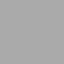

In [31]:
fil = .1
map_only = True

interpolator = PLI(mesh)
nsteps = np.array([10,10,10])
npts = nsteps[0]*nsteps[1]*nsteps[2]
stratigraphy_builder = GeologicalFeatureInterpolator(
    interpolator=interpolator,
    name='stratigraphy')
solver = 'lu'
#fil = 1
# add a single value point
stratigraphy_builder.add_point([0.1,0.1,5000.1],0)
for i, r in data.iterrows():
    if np.random.rand()*2 < fil:
        if map_only and r['z'] < 9000:
            continue
        if r['event'] == 0 and r['x'] > 200 and r['x'] < 9800 and r['y'] > 200 and r['y'] < 6800 and r['z'] > 5200 and r['z'] < 9800:
            stratigraphy_builder.add_strike_and_dip([r['x'],r['y'],r['z']],r['strike'],r['dip'])

stratigraphy = stratigraphy_builder.build(solver='lu',cgw=0.001)
viewer = LavaVuModelViewer(background="white")

# determine the number of unique surfaces in the model from the input data and then calculate isosurfaces for this
# unique = np.unique(stratigraphy_builder.interpolator.get_control_points()[:,3])
viewer.add_scalar_field(boundary_points,(38,55,30),
                      'box',
                     paint_with=stratigraphy,
                     cmap='prism')
viewer.add_data(stratigraphy)
viewer.lv.rotate([-57.657936096191406, -13.939384460449219, -6.758780479431152])
viewer.interactive()



### Modelling folds using structural geology

The following section will describe how the fold axis, fold axial surface and fold vergence can be used to help constrain the shape of the folded surface.
To do this we need to build a fold frame which is curvilinear coordinate system based around the fold axis and the fold axial surface. 

There are three coordinates to the fold frame:
* coordinate 0 is the axial surface of the fold and is parallel to the axial foliation
* coordinate 1 is the fold axis direction field and is orthogonal to the axial foliation
* coordinate 2 is orthogonal to both the fold axis direction field and axial foliation and is roughly parallel to the extension direction of the fold 

![Fold Frame](images/fold_frame.png)

Three direction vectors are defined by the normalised gradient of these fields:
* $e_0$ - red
* $e_1$ - green
* $e_2$ - blue

The orientation of the folded foliation can be defined by rotating $e_1$ around $e_0$ by the fold axis rotation angle $\alpha_P$ to give the orientation of the fold axis. The orientation of the folded foliation can then be defined by rotating the plane defined by the fold axis and $e_0$ around the fold axis by the fold limb rotation angle $\alpha_L$. 

![Fold constraints](images/fold_constraints.png)

A `FoldFrame` is a `StructuralFrame` with specific functions for calculating geometrical aspects of the fold. The `StructuralFrame` is a list of three `GeologicalFeature` - each feature corresponding to a coordinate of the fold frame. The features can be accessed by either directly accessing the features using the attribute features `frame.features[0]` returns the first coordinate of the fold frame. Alternatively the `__getitem__` method for the `StructuralFrame` will return the feature associated with the coordinate e.g. `frame[0]` returns the first coordinate.


A `StructuralFrameBuilder` manages setting up the interpolators for the different geological features and installing the required constraints so that the coordinates of the fold frame are orthogonal. The `StructuralFrame` builder is a generic builder that can be used to build either a `FoldFrame` or a `StructuralFrame` using any interpolation method/support. 
The same arguments can be used to add data to a structural frame builder as a geological feature builder, only an additional argument `coord` needs to be specified to assign which `StructuralFrame` coordinate to build.
e.g. for strike and dip data 
```Python
builder.add_strike_and_dip(pos,strike,dip,coord=0)
```
Adds a strike and dip observation to the first coordinate.

In [32]:
a = np.array([0,0,1])
b = np.array([0,0,1])
np.dot(a,b)

1

In [33]:
fold_frame_interpolator = PLI(mesh)
fold_frame_builder = StructuralFrameBuilder(
    interpolator=fold_frame_interpolator,
    mesh=mesh,
    name='F1_fold_frame')
# Interfacing with dataframes should be done using a convenience wrapper function
fold_frame_builder.add_strike_and_dip([1000,1000,5200],0,90,coord=0)
fold_frame_builder.add_strike_and_dip([1000,1000,5200],90,90,coord=1)

f1_frame = fold_frame_builder.build(
    frame=FoldFrame,
    solver='lu',
)


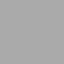

In [34]:
viewer = LavaVuModelViewer(background="white")


viewer.add_scalar_field(boundary_points,(38,55,30),
                      'f1_0',
                     paint_with=f1_frame.features[0],
                     cmap='prism')
viewer.add_scalar_field(boundary_points,(38,55,30),
                      'f1_1',
                     paint_with=f1_frame.features[1],
                     cmap='prism')
viewer.add_data(f1_frame.features[1])
viewer.add_data(f1_frame.features[0])

viewer.interactive()

### Creating a fold
Once the fold frame has been built a `FoldEvent` can be defined. The `FoldEvent` links the `FoldFrame` with the fold shape that is defined by the rotation angles. 
A `FoldEvent`can be created from a FoldFrame instance:
```Python
fold = FoldEvent(f1_frame)
```

To interpolate a folded surface the `DiscreteFoldInterpolator` needs to be used - this interpolator is similar to the `PiecewiseLinearInterpolator` in that is is based on the tetrahedral mesh - however additional constraints are added to constrain the geometry of the folded surface. 

A `DiscreteFoldInterpolator` can either be created from a mesh and fold e.g.
```Python
fold_interpolator = DFI(mesh,fold)
```
Or coppied from an existing `PiecewiseLinearInterpolator` instance and fold  where the data points are coppied across from the - e.g.
```Python
fold_interpolator = DFI.from_piecewise_linear_and_fold(interpolator, fold)
```

The interpolator can then be linked to a GeologicalFeatureInterpolator in the same way as other interpolators.

In [9]:
fold = FoldEvent(f1_frame)
fold_interpolator = DFI.from_piecewise_linear_and_fold(interpolator,fold)
stratigraphy_builder2 = GeologicalFeatureInterpolator(
    interpolator=fold_interpolator,
    name='stratigraphy_fold')
solver = 'lu'

### Calculating the fold rotation angles
![Fold rotation angles](./images/fold_rotation_angles.png)


`get_gradient_constraints()` returns an array N,6 array with the xyz and normal vector components of the gradient control points. We can use these arrays to calculate the fold axis using the intersection lineation between the axial foliation and the normal to the folded foliation. The fold axis rotation angle can then be calculated by finding the angle between the fold axis direction field and the intersection lineation. A SVariogram can then be used to automatically pick the wavelength of the fold.


In [35]:

xyz = stratigraphy_builder.interpolator.get_norm_constraints()[:,:3]
s0g = stratigraphy_builder.interpolator.get_norm_constraints()[:,3:]
l1 = f1_frame.calculate_intersection_lineation(np.hstack([xyz,s0g]))
far = f1_frame.calculate_fold_axis_rotation(np.hstack([xyz,l1]))
s1 = f1_frame.features[0].evaluate_value(xyz)
s1gy = f1_frame.features[1].evaluate_value(xyz)
# axis_svariogram = SVariogram(s1gy,far)
# guess = np.array(axis_svariogram.find_wavelengths())
# guess[0] = guess[1]/2.

In [36]:
fold.fold_axis = np.mean(l1,axis=0)
print(fold.fold_axis)

[-6.51626577e-06 -5.00013645e-01 -8.66017526e-01]


Rather than interpolate the angle directly we interpolate the gradient of the curve. Which can be calculated by finding the tangent of the angle. This means that the interpolated value will not be > 90 or < -90. We use SciPy's RBF to interpolate the fold rotation angles. A smoothing parameter prevents overfitting of the interpolated angles.

#### Evaluate the fold limb rotation angle<br>
The fold axis can be queried for any location in the model. The axis is a unit vector and does not need to be normalised here. THe fold limb rotation angle is calculated by finding the angle between the folded foliation and the axial foliation in the fold frame. The calculated axis can be used by passing an N,3 array of the fold axis for every N locations. Or if no axis is specified the local intersection lineation is used.

In [37]:
axis = fold.get_fold_axis_orientation(xyz)
flr = f1_frame.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
# limb_svariogram = SVariogram(s1,flr)
# guess = limb_svariogram.find_wavelengths()
# guess = np.array(limb_svariogram.find_wavelengths())
# guess[0] /=2

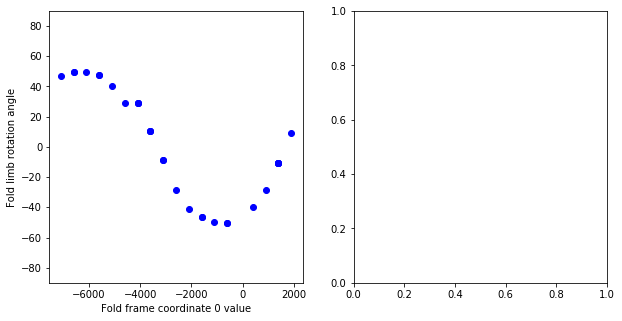

In [38]:
fig, ax = plt.subplots(1,2,figsize=(10,5),)
ax[0].plot(s1,flr,'bo')
ax[0].set_ylabel('Fold limb rotation angle')
ax[0].set_xlabel('Fold frame coordinate 0 value')

# npairsax = ax[1].twinx()
# npairsax.bar(lags,npairs,lags[1]-lags[0],color='grey',alpha=0.5)
# npairsax.set_ylabel('Number of Pairs')

# ax[1].plot(lags,variogram,'bo')
# ax[1].set_ylabel('Fold limb variogram')
# ax[1].set_xlabel('S-Variogram lags')


t = ax[0].set_ylim(-90,90)

In [39]:
def fourier_series(x,c0,c1,c2,w):
    v = np.array(x.astype(float))
    v.fill(c0)
    v = c0 + c1*np.cos(2*np.pi/w*x) + c2*np.sin(2*np.pi/w*x)
    return np.rad2deg(np.arctan(v))

In [40]:
from scipy.optimize import curve_fit
wavelength_guess = 8000.0001
flr_tan = np.tan(np.deg2rad(flr))

guess = np.zeros(4)
guess[3] = wavelength_guess

popt, pcov = curve_fit(fourier_series,s1,flr_tan,guess)
xi = np.linspace(f1_frame.features[0].min(),f1_frame.features[0].max(),1000)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))
# flr_feature = FoldRotationAngleFeature(f1_frame,fold_limb_rotation)
fold.fold_limb_rotation = fold_limb_rotation

The fold rotation angle function is added to the **FoldEvent**

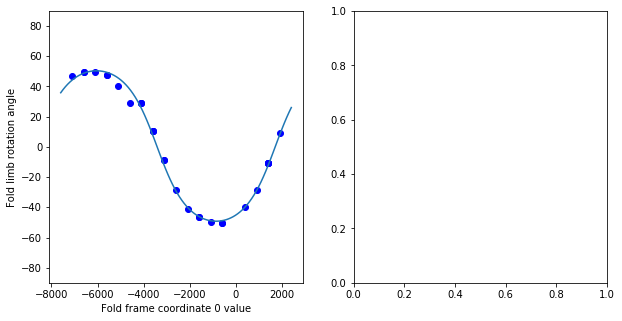

In [41]:
fig, ax = plt.subplots(1,2,figsize=(10,5),)
ax[0].plot(s1,flr,'bo')
ax[0].set_ylabel('Fold limb rotation angle')
ax[0].set_xlabel('Fold frame coordinate 0 value')
x = np.linspace(f1_frame.features[0].min(),f1_frame.features[0].max(),100)
ax[0].plot(x,fold.fold_limb_rotation(x))
# npairsax = ax[1].twinx()
# npairsax.bar(lags,npairs,lags[1]-lags[0],color='grey',alpha=0.5)
# npairsax.set_ylabel('Number of Pairs')

# ax[1].plot(lags,variogram,'bo')
# ax[1].set_ylabel('Fold limb variogram')
# ax[1].set_xlabel('S-Variogram lags')


t = ax[0].set_ylim(-90,90)

In [42]:
fold.fold_limb_rotation = fold_limb_rotation

### Define interpolation weights
The DiscreteFoldInterpolator has the ability to weigh the different geometrical properties of the
fold differently in the least squares system. Much the same as data points and regularisation are
handled differently for standard interpolation.

* **fold_orientation** is the weight of the dot product between a vector parallel to the folded foliation and the gradient of the scalar field
* **fold_axis** is the weight of the dot product between the fold axis and the interpolated foliation
* **fold_normalisation** the thickness of the scalar field
* **fold_regularisation** is the fold regularisation term that ensures the fold is smooth along strike

These weights need to be added to a dictionary and then passed to the feature builder along with the fold

In [43]:
fold_weights = {}
fold_weights['fold_orientation'] = 10. # reference values?
fold_weights['fold_axis'] = 10. # reference values?
fold_weights['fold_normalisation'] = 1. # reference values?
fold_weights['fold_regularisation'] = .100# reference values?
stratigraphy_builder.interpolator = fold_interpolator
# stratigraphy_builder.interpolator.n_g = 0
# stratigraphy_builder.interpolator.n_i = 0
folded_stratigraphy = stratigraphy_builder2.build(solver='cg',
                                                 cgw=0.00,
                                                 fold_weights=fold_weights,
                                                 fold=fold
                                                 )


53646


### Visualising Results<br>
We can visualise the surfaces for isovalues of the fold frame or interpolated surface. Normal vectors to the scalar fields can be visualised for evaluation points (if too many points are chosen it can be difficult to see the locations. We suggest slicing numpy arrays to create regularly sampled locations.

Another option is to plot the fold constraint vectors:

````Python
viewer.add_fold(fold,locations)
```


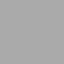

In [44]:
viewer = LavaVuModelViewer(background="white")


viewer.add_isosurface(folded_stratigraphy,
                       colour='purple',
#                        nslices=10,
                       # paint_with=f1_frame.features[0]
                       )

# viewer.add_isosurface(stratigraphy)
locations = mesh.barycentre[::20,:]
viewer.add_fold(fold,locations)
# viewer.add_data(stratigraphy)
viewer.add_scalar_field(boundary_points,(38,55,30),
                      'box',
                     paint_with=folded_stratigraphy,
                     cmap='prism')
#viewer.add_vector_field(f1_frame.features[0], locations=locations, colour='blue')
viewer.interactive()